In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pydicom
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose, ScaleIntensityd, Lambdad, CastToTyped
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

In [3]:
import os
from dotenv import load_dotenv
from kaggle.api.kaggle_api_extended import KaggleApi

# Use find_dotenv to locate the file 
from dotenv import find_dotenv
load_dotenv(find_dotenv())

if not os.environ.get('KAGGLE_USERNAME'):
    print("Error: Environment variables not loaded. Check your .env file!")

In [3]:
dest_path = "./data"
from kaggle.api.kaggle_api_extended import KaggleApi
        # Set up Kaggle API
os.makedirs(dest_path, exist_ok=True)
api = KaggleApi()
api.authenticate()

        # Download dataset to dest_path
dataset_slug = "omarxadel/chaos-combined-ct-mr-healthy-abdominal-organ"
print("Downloading DataSet...")
api.dataset_download_files(
    dataset_slug,
    path=dest_path,
    unzip=True,
    quiet=False
)
print("Download complete — check:", dest_path)


Dataset URL: https://www.kaggle.com/datasets/omarxadel/chaos-combined-ct-mr-healthy-abdominal-organ


100%|██████████| 1.87G/1.87G [02:19<00:00, 14.4MB/s]



Download complete — check: ./data


In [ ]:
import glob
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd

train_pth = "./data/CHAOS_Train_Sets/Train_Sets/MR"
def load_data(data_pth):
    #  Update the loader
    loader = Compose([
        LoadImaged(keys=["t1_in", "t1_out", "t2", "t1_label", "t2_label"]),
        EnsureChannelFirstd(keys=["t1_in", "t1_out", "t2", "t1_label", "t2_label"]),
        # SCALING: Maps MRI signal to 0.0 - 1.0
        ScaleIntensityd(keys=["t1_in", "t1_out", "t2"]),

        # THRESHOLDING: Isolate Liver (55-70) and convert to Binary (0 or 1)
        Lambdad(
            keys=["t1_label", "t2_label"],
            func=lambda x: ((x >= 55) & (x <= 70)).astype(np.float32)
        ),
    ])

    data_list = []

    for i in range(1, 41):
        subject_path = os.path.join(data_pth, str(i))
        if not os.path.exists(subject_path):
            continue
            
        # Manually get lists of PNG files for the labels
        t1_label_path = os.path.join(subject_path, "T1DUAL/Ground")
        t2_label_path = os.path.join(subject_path, "T2SPIR/Ground")
        
        # Sort them to match the DICOM slice order
        t1_labels = sorted(glob.glob(os.path.join(t1_label_path, "*.png")))
        t2_labels = sorted(glob.glob(os.path.join(t2_label_path, "*.png")))

        paths = {
            "t1_in": os.path.join(subject_path, "T1DUAL/DICOM_anon/InPhase"),
            "t1_out": os.path.join(subject_path, "T1DUAL/DICOM_anon/OutPhase"),
            "t2": os.path.join(subject_path, "T2SPIR/DICOM_anon"),
            "t1_label": t1_labels, # List of files, not folder
            "t2_label": t2_labels  # List of files, not folder
        }
        
        # Verify both PNG folders have files before loading
        if all(os.path.exists(p) if isinstance(p, str) else len(p) > 0 for p in paths.values()):
            try:
                loaded_data = loader(paths)
                data_list.append(loaded_data)
                print(f"Successfully loaded Subject {i}")
            except Exception as e:
                # This will now show the SPECIFIC error (e.g., shape mismatch)
                print(f"Error loading Subject {i}: {e}")

    return data_list

In [37]:
train_list = load_data(train_pth)

Successfully loaded Subject 1
Successfully loaded Subject 2
Successfully loaded Subject 3
Successfully loaded Subject 5
Successfully loaded Subject 8
Successfully loaded Subject 10
Successfully loaded Subject 13
Successfully loaded Subject 15
Successfully loaded Subject 19
Successfully loaded Subject 20
Successfully loaded Subject 21
Successfully loaded Subject 22
Successfully loaded Subject 31
Successfully loaded Subject 32
Successfully loaded Subject 33
Successfully loaded Subject 34
Successfully loaded Subject 36
Successfully loaded Subject 37
Successfully loaded Subject 38
Successfully loaded Subject 39


In [38]:
for item in train_list:
    # 1. Permute from (D, H, W) to (H, W, D)
    item['t1_label'] = item['t1_label'].permute(1, 2, 0)
    
    # 2. Add channel dim at index 0: (H, W, D) -> (1, H, W, D)
    item['t1_label'] = item['t1_label'].unsqueeze(0)

# Check the result for the first subject
print(f"New shape: {train_list[0]['t1_label'].shape}")

New shape: torch.Size([1, 256, 256, 35])


In [39]:
print(train_list[0]['t1_in'].meta)

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, '00200032': {'vr': 'DS', 'Value': [-232.99694347381, -238.76329636573, -39.239204406738]}, '00280030': {'vr': 'DS', 'Value': [1.89453125, 1.89453125, 5.500000224394059]}, 'spacing': array([1.89453125, 1.89453125, 5.50000022]), 'lastImagePositionPatient': array([-232.99694347, -238.76329637,  147.76080322]), spatial_shape: (256, 256, 35), space: RAS, original_affine: array([[ -1.89453125,   0.        ,   0.        , 232.99694347],
       [  0.        ,  -1.89453125,   0.        , 238.76329637],
       [  0.        ,   0.        ,   5.50000022, -39.23920441],
       [  0.        ,   0.        ,   0.        ,   1.        ]]), affine: tensor([[ -1.8945,   0.0000,   0.0000, 232.9969],
        [  0.0000,  -1.8945,   0.0000, 238.7633],
        [  0.0000,   0.0000,   5.5000, -39.2392],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64), original_channel_dim: nan, 'filename_or_obj': 'data\\CHAOS_Train_Sets\

In [40]:
print(train_list[0]['t2'].meta)

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, '00200032': {'vr': 'DS', 'Value': [-192.65368556976, -192.7957458496, -77.092163085937]}, '00280030': {'vr': 'DS', 'Value': [1.54296875, 1.54296875, 7.699999999999916]}, 'spacing': array([1.54296875, 1.54296875, 7.7       ]), 'lastImagePositionPatient': array([-192.65368557, -192.79574585,  192.40783691]), spatial_shape: (256, 256, 36), space: RAS, original_affine: array([[ -1.54296875,   0.        ,   0.        , 192.65368557],
       [  0.        ,  -1.54296875,   0.        , 192.79574585],
       [  0.        ,   0.        ,   7.7       , -77.09216309],
       [  0.        ,   0.        ,   0.        ,   1.        ]]), affine: tensor([[ -1.5430,   0.0000,   0.0000, 192.6537],
        [  0.0000,  -1.5430,   0.0000, 192.7957],
        [  0.0000,   0.0000,   7.7000, -77.0922],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64), original_channel_dim: nan, 'filename_or_obj': 'data\\CHAOS_Train_Sets\\

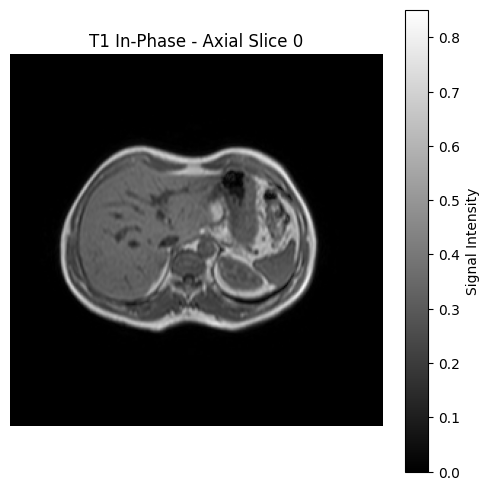

In [41]:
# get image for a single scan
slice_data = train_list[0]['t1_in'][:, :, :, 30].cpu().numpy().squeeze()

plt.figure(figsize=(6, 6))
plt.imshow(slice_data.T, cmap='gray',origin='upper') 
plt.colorbar(label='Signal Intensity')
plt.title("T1 In-Phase - Axial Slice 0")
plt.axis('off')
plt.show()

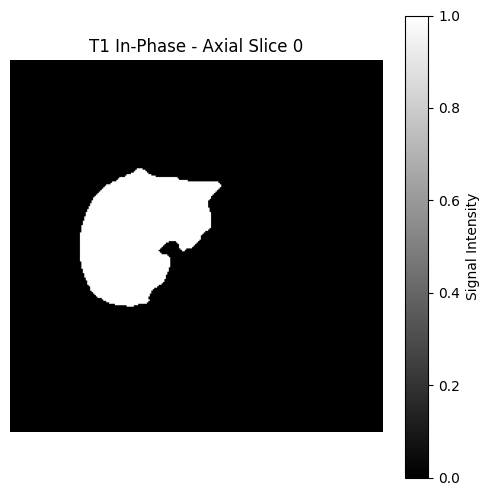

[0. 1.]


In [42]:
slice_label = train_list[0]['t1_label'][:, :, :, 30].cpu().numpy().squeeze()

plt.figure(figsize=(6, 6))
plt.imshow(slice_label.T, cmap='gray',origin='upper') 
plt.colorbar(label='Signal Intensity')
plt.title("T1 In-Phase - Axial Slice 0")
plt.axis('off')
plt.show()

print(np.unique(train_list[0]['t1_label'][:, :, :, 30].cpu().numpy().squeeze()))

In [43]:
print(len(train_list))

20


In [47]:
import random

all_subjects = [i for i in range(len(train_list))]

# Shuffle and split
random.seed(42) # For reproducibility
random.shuffle(all_subjects)

train_ids = all_subjects[:16]
val_ids = all_subjects[16:]

print(f"Training on: {sorted(train_ids)}")
print(f"Validating on: {sorted(val_ids)}")

# Use list comprehension to pick the subjects by index
train_sub = [train_list[i] for i in train_ids]
val_sub = [train_list[i] for i in val_ids]

print(f"Training on {len(train_sub)} subjects")
print(f"Validating on {len(val_sub)} subjects")

Training on: [1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Validating on: [0, 3, 7, 8]
Training on 16 subjects
Validating on 4 subjects


In [61]:
import torch.nn.functional as F

def create_2d_list(subset_list):
    all_2d_slices = []
    target_size = (256, 256)
    
    for subject in subset_list:
        num_slices = subject["t1_in"].shape[-1] 
        
        for s in range(num_slices):
            # 1. Extract both phases
            img_in = subject["t1_in"][:, :, :, s].clone()   # [1, H, W]
            img_out = subject["t1_out"][:, :, :, s].clone() # [1, H, W]
            lab_slice = subject["t1_label"][:, :, :, s].clone()
            
            # 2. Stack them into 2 channels: [2, H, W]
            img_multichannel = torch.cat([img_in, img_out], dim=0)
            
            # 3. Resize if needed
            if img_multichannel.shape[1:] != target_size:
                img_multichannel = F.interpolate(img_multichannel[None], size=target_size, mode='bilinear')[0]
                lab_slice = F.interpolate(lab_slice[None], size=target_size, mode='nearest')[0]
            
            all_2d_slices.append({"image": img_multichannel, "label": lab_slice})
            
    return all_2d_slices

# Re-run your list creation
train_2d_list = create_2d_list(train_sub)
val_2d_list = create_2d_list(val_sub)

# Check all 2D slices for size consistency
for i, entry in enumerate(train_2d_list):
    shape = entry['image'].shape
    if shape != (2, 256, 256):
        print(f"Mismatch found at Index {i}: Shape is {shape}")
        # If you need to find which patient this belongs to:
        # print(f"Problem Subject: {data_list[i // 35]['t1_in_meta_dict']['filename_or_obj']}")

In [57]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    train_2d_list, 
    batch_size=16, 
    shuffle=True, 
    num_workers=0  
)

val_loader = DataLoader(
    val_2d_list, 
    batch_size=1, 
    shuffle=False
)

In [ ]:
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = UNet(
    spatial_dims=2,          # 2D segmentation
    in_channels=2,           # MRI is grayscale, in-phase and out-phase
    out_channels=1,          # Output is binary (Liver vs Background)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,         # Adds residual connections for better gradient flow
).to(device)

# Loss and Optimizer
loss_function = DiceLoss(sigmoid=True) # Automatically applies Sigmoid to the output
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Metric for validation
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [59]:
import torch

max_epochs = 50
val_interval = 2 # Check validation every 2 epochs
best_metric = -1
best_metric_epoch = -1

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        if step % 20 == 0:
            print(f"{step}/{len(train_2d_list) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    avg_loss = epoch_loss / step
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

    # Validation Phase
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                
                # Get the prediction
                val_outputs = model(val_inputs)
                
                # Threshold to binary (0 or 1)
                val_outputs = (torch.sigmoid(val_outputs) > 0.5).float()
                
                # Compute Dice
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final mean dice
            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_liver_unet.pth")
                print("--- Saved New Best Model ---")
            
            print(f"Current Epoch: {epoch + 1} | Current Mean Dice: {metric:.4f} | Best Dice: {best_metric:.4f} at Epoch {best_metric_epoch}")

print(f"Training Completed. Best Cumulative Dice: {best_metric:.4f} at Epoch {best_metric_epoch}")

----------
Epoch 1/50
20/32, train_loss: 0.9336
Epoch 1 Average Loss: 0.9322
----------
Epoch 2/50
20/32, train_loss: 0.9411
Epoch 2 Average Loss: 0.9176
--- Saved New Best Model ---
Current Epoch: 2 | Current Mean Dice: 0.5625 | Best Dice: 0.5625 at Epoch 2
----------
Epoch 3/50
20/32, train_loss: 0.9246
Epoch 3 Average Loss: 0.8979
----------
Epoch 4/50
20/32, train_loss: 0.9079
Epoch 4 Average Loss: 0.8912
--- Saved New Best Model ---
Current Epoch: 4 | Current Mean Dice: 0.5891 | Best Dice: 0.5891 at Epoch 4
----------
Epoch 5/50
20/32, train_loss: 0.9392
Epoch 5 Average Loss: 0.8856
----------
Epoch 6/50
20/32, train_loss: 0.9354
Epoch 6 Average Loss: 0.8804
--- Saved New Best Model ---
Current Epoch: 6 | Current Mean Dice: 0.6763 | Best Dice: 0.6763 at Epoch 6
----------
Epoch 7/50
20/32, train_loss: 0.8402
Epoch 7 Average Loss: 0.8759
----------
Epoch 8/50
20/32, train_loss: 0.9314
Epoch 8 Average Loss: 0.8701
--- Saved New Best Model ---
Current Epoch: 8 | Current Mean Dice: 0.